In [1]:
from pyspark.sql.types import StringType
from pyspark import SQLContext, SparkContext
from collections import namedtuple
from pyspark.sql import functions as F
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType, Row, ArrayType, StringType
import re
from pyspark.sql import SparkSession

import numpy as np

from pyspark.mllib.feature import HashingTF, IDF
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes, DecisionTreeClassifier

from pyspark.ml.feature import  HashingTF,Tokenizer

In [2]:
spark = SparkSession \
    .builder \
    .appName("COMP 4651") \
    .getOrCreate()

In [3]:
# sqlContext = SQLContext(sc)



#compute the length of song
size_ = udf(lambda xs: len(xs), IntegerType())

#filter out null song value  note: filter == where, dunno why do they create two functions...
raw_df = spark.read.json("data/lyrics.json").where( (col('lyrics')).isNotNull() ).filter(size_(col('lyrics')) >0)

# .na.drop(subset=[""])
# raw_df.select(raw_df['lyrics'], F.where((raw_df['index'] == 160))).show()
raw_df
raw_df.show()

+---------------+-----+-----+--------------------+--------------------+----+
|         artist|genre|index|              lyrics|                song|year|
+---------------+-----+-----+--------------------+--------------------+----+
|beyonce-knowles|  Pop|    0|Oh baby, how you ...|           ego-remix|2009|
|beyonce-knowles|  Pop|    1|playin' everythin...|        then-tell-me|2009|
|beyonce-knowles|  Pop|    2|If you search
For...|             honesty|2009|
|beyonce-knowles|  Pop|    3|Oh oh oh I, oh oh...|     you-are-my-rock|2009|
|beyonce-knowles|  Pop|    4|Party the people,...|       black-culture|2009|
|beyonce-knowles|  Pop|    5|I heard
Church be...|all-i-could-do-wa...|2009|
|beyonce-knowles|  Pop|    6|This is just anot...|  once-in-a-lifetime|2009|
|beyonce-knowles|  Pop|    7|Waiting, waiting,...|             waiting|2009|
|beyonce-knowles|  Pop|    8|[Verse 1:]
I read...|           slow-love|2009|
|beyonce-knowles|  Pop|    9|N-n-now, honey
Yo...|why-don-t-you-lov...|2009|

In [4]:
STOPWORDS_PATH = 'data/stopwords.txt'
stopwords = set(spark.read.text(STOPWORDS_PATH).rdd.map(lambda x: x.value).collect())

In [5]:
raw_df.select('genre').rdd.distinct().collect()

[Row(genre=u'Indie'),
 Row(genre=u'Not Available'),
 Row(genre=u'Hip-Hop'),
 Row(genre=u'Pop'),
 Row(genre=u'Folk'),
 Row(genre=u'Jazz'),
 Row(genre=u'Rock'),
 Row(genre=u'Metal'),
 Row(genre=u'Electronic'),
 Row(genre=u'Other'),
 Row(genre=u'Country'),
 Row(genre=u'R&B')]

In [68]:
genre_type = 'R&B'
indie_lyrics = raw_df.filter((col('genre')) == genre_type).select('index','lyrics').rdd.map(lambda x: (x[0],re.sub(r"[^a-zA-Z0-9]+", ' ', x[1]).split(" ") )).map(lambda x:(x[0], [ word.lower() for word in x[1] if word.lower() not in stopwords and len(word)]))
indie_lyrics.take(2)

[(1539,
  [u'little',
   u'wallflower',
   u'shelf',
   u'standing',
   u'never',
   u'nerve',
   u'take',
   u'chance',
   u'let',
   u'little',
   u'girl',
   u'dance',
   u'let',
   u'little',
   u'girl',
   u'dance',
   u'let',
   u'little',
   u'girl',
   u'dance',
   u'never',
   u'danced',
   u'let',
   u'floor',
   u'let',
   u'floor',
   u'let',
   u'little',
   u'girl',
   u'dance',
   u'let',
   u'little',
   u'girl',
   u'dance',
   u'wants',
   u'give',
   u'try',
   u'let',
   u'little',
   u'girl',
   u'let',
   u'little',
   u'girl',
   u'shes',
   u'little',
   u'wallflower',
   u'shelf',
   u'standing',
   u'got',
   u'nerve',
   u'take',
   u'chance',
   u'let',
   u'little',
   u'girl',
   u'dance',
   u'let',
   u'little',
   u'girl',
   u'wants',
   u'pass',
   u'buddy',
   u'cant',
   u'see',
   u'wants',
   u'dance',
   u'wants',
   u'dance',
   u'shes',
   u'little',
   u'wallflower',
   u'shelf',
   u'standing',
   u'got',
   u'nerve',
   u'take',
   u'chance'

In [69]:
indie_word_list =indie_lyrics.flatMap(lambda x: [(word, 1) for word in x[1]]).reduceByKey(lambda a,b:a+b).sortBy(lambda x:-x[1]).map(lambda x:x[0]).take(200)

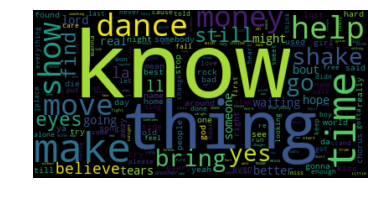

In [70]:
from wordcloud import WordCloud

wordcloud = WordCloud().generate(' '.join(indie_word_list))

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')

plt.axis("off")

# lower max_font_size
# wordcloud = WordCloud(max_font_size=40).generate()
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
plt.show()

In [71]:
fig.savefig( genre_type+'.png',dpi = 1000)

In [34]:

word_count = filtered_lyrics.flatMap(lambda x: [(x[0],word) for word in x[1]] ).map(lambda x: (x[0], (x[1],1))).reduceByKey(lambda a,b: (a[0], (a[1]+b[1]) ) )
word_count.cache()
word_count.take(20)

[(u'Electronic', (u'reverse', 845849)),
 (u'Hip-Hop', (u'horns', 7138715)),
 (u'R&B', (u'little', 392586)),
 (u'Other', (u'little', 735978)),
 (u'Country', (u'verse', 1376500)),
 (u'Jazz', (u've', 752401)),
 (u'Folk', (u'rise', 233633)),
 (u'Pop', (u'oh', 5607817)),
 (u'Not Available', (u'santa', 3026000)),
 (u'Rock', (u'lot', 11113508)),
 (u'Indie', (u'feel', 323108)),
 (u'Metal', (u'gods', 2229136))]